In [2]:
import scipy.io as sio
import numpy as np
import emd
import os
import h5py
from scipy.stats import binned_statistic
import pingouin as pg
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy.stats import zscore
from scipy.signal import convolve2d

In [3]:
def calculate_cog(frequencies, angles, amplitudes, ratio):
    """
       Calculate the Center of Gravity (CoG) of an FPP plots of cycles.

       Parameters:
       frequencies (numpy.ndarray): An array of frequencies corresponding to FPP frequencies.
       angles (numpy.ndarray): An array of phase angles in degrees.
       amplitudes (numpy.ndarray): An array of magnitude values (can be power).
           - If 2D, it represents magnitude values for multiple frequency bins.
           - If 3D, it represents magnitude values for multiple frequency bins across multiple trials or subjects.
       ratio (float): A ratio threshold for selecting magnitude values in the phase direction .

       Returns:
       numpy.ndarray: The Center of Gravity (CoG) for the FPP plot as frequency and phase.
           - For 2D amplitudes: A 2D array containing CoG values for frequency and phase.
           - For 3D amplitudes: A 2D array containing CoG values for frequency and phase cycle.

       Notes:
       - This function calculates the Center of Gravity (CoG) of the FPP plots.
       - It can handle 2D or 3D amplitude arrays, representing either single or multiple cycles.
       """
    angles = np.deg2rad(angles)
    cog = np.empty((0, 2))

    if amplitudes.ndim == 2:
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=1))
        denominator = np.sum(amplitudes)
        cog_f = numerator / denominator
        floor = np.floor(cog_f).astype(int) - frequencies[0]
        ceil = np.ceil(cog_f).astype(int) - frequencies[0]
        new_fpp = np.where(amplitudes >= np.max(amplitudes[[floor, ceil], :]) * ratio, amplitudes, 0)
        cog_ph = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog = np.array([cog_f, cog_ph])

    elif amplitudes.ndim == 3:
        indices_to_subset = np.empty((amplitudes.shape[0], 2)).astype(int)
        cog = np.empty((amplitudes.shape[0], 2))
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=2), axis=1)
        denominator = np.sum(amplitudes, axis=(1, 2))
        cog_f = (numerator / denominator)

        vectorized_floor = np.vectorize(np.floor)
        vectorized_ceil = np.vectorize(np.ceil)
        indices_to_subset[:, 0] = vectorized_floor(cog_f) - frequencies[0]
        indices_to_subset[:, 1] = vectorized_ceil(cog_f) - frequencies[0]

        max_amps = np.max(amplitudes[np.arange(amplitudes.shape[0])[:, np.newaxis], indices_to_subset, :], axis=(1, 2))
        print(max_amps.shape)

        for i, max_amp in enumerate(max_amps):
            new_fpp = np.where(amplitudes[i] >= max_amp * ratio, amplitudes[i], 0)
            cog[i, 1] = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog[:, 0] = cog_f

    return cog
def peak_cog(frequencies, angles, amplitudes, ratio):
    """
       Calculate the Center of Gravity (CoG) and snap to the nearest peak in the FPP array.

       Parameters:
       frequencies (numpy.ndarray): An array of frequencies.
       angles (numpy.ndarray): An array of phase angles in degrees.
       amplitudes (numpy.ndarray): An array of magnitude values (can be power).
           - If 2D, it represents magnitude values for multiple phase bins.
           - If 3D, it represents magnitude values for multiple phase bins across multiple trials or subjects.
       ratio (float): A ratio threshold for selecting magnitude values in the phase direction.

       Returns:
       numpy.ndarray: Snapped peaks of each FPP cycle .
           - For 2D amplitudes: A 2D array containing CoG peaks for frequency and phase.
           - For 3D amplitudes: A 2D array containing CoG peaks for frequency and phase for each cycle.

       Notes:
       - This function calculates the Center of Gravity (CoG) of the passed FPP cycles and their respective magnitude
       peaks.
       - The CoG is then shifted to the nearest peak of Euclidean distance treating frequency as linear and phase as
       circular.
       """

    def nearest_peaks(frequency, angle, amplitude, ratio):
        peak_indices = peak_local_max(amplitude, min_distance=1, threshold_abs=0)
        cog_f = calculate_cog(frequency, angle, amplitude, ratio)

        if peak_indices.shape[0] == 0:
            cog_peak = cog_f
        else:
            cog_fx = np.array([cog_f[0], cog_f[0] * np.cos(np.deg2rad(cog_f[1] - angle[0])),
                               cog_f[0] * np.sin(np.deg2rad(cog_f[1] - angle[0]))])
            peak_loc = peak_loc = np.empty((peak_indices.shape[0], 4))
            peak_loc[:, [0, 1]] = np.array([frequency[peak_indices.T[0]], angle[peak_indices.T[1]]]).T
            peak_loc[:, 2] = peak_loc[:, 0] * np.cos(np.deg2rad(peak_loc[:, 1] - angle[0]))
            peak_loc[:, 3] = peak_loc[:, 0] * np.sin(np.deg2rad(peak_loc[:, 1] - angle[0]))
            peak_loc = peak_loc[:, [0, 2, 3]]
            distances = np.abs(peak_loc - cog_fx)

            cog_pos = peak_indices[np.argmin(np.linalg.norm(distances, axis=1))]

            cog_peak = np.array([frequency[cog_pos[0]], angle[cog_pos[1]]])

        return cog_peak

    if amplitudes.ndim == 2:
        cog = nearest_peaks(frequencies, angles, amplitudes, ratio)
    elif amplitudes.ndim == 3:
        cog = np.empty((amplitudes.shape[0], 2))
        for i, fpp in enumerate(amplitudes):
            cog[i] = nearest_peaks(frequencies, angles, fpp, ratio)
    return cog

def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

def boxcar_smooth(x, boxcar_window):
    """
    Smooth a 1D or 2D array using a boxcar window.

    Parameters:
    - x (numpy.ndarray): Input array to be smoothed.
    - boxcar_window (int or tuple): Size of the boxcar window for smoothing.
      For 1D array, an integer representing the window size.
      For 2D array, a tuple (t, f) representing window sizes along the time (t) and frequency (f) dimensions.

    Returns:
    - numpy.ndarray: Smoothed array using the boxcar window.

    Notes:
    - If the input array is 1D, the boxcar window size is adjusted to be odd.
    - If the input array is 2D, separate boxcar windows are created for the time (t) and frequency (f) dimensions.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal_1d = np.random.rand(100)  # Replace with your actual 1D signal
    window_size_1d = 5
    smoothed_1d = boxcar_smooth(signal_1d, window_size_1d)
    print(smoothed_1d)

    signal_2d = np.random.rand(100, 50)  # Replace with your actual 2D signal
    window_size_2d = (5, 3)
    smoothed_2d = boxcar_smooth(signal_2d, window_size_2d)
    print(smoothed_2d)
    ```
    """
    # Check if the input array x is 1-dimensional
    if x.ndim == 1:
        # Check if the boxcar window size is even, and if so, make it odd by adding 1
        if boxcar_window % 2 == 0:
            boxcar_window += 1
        # Create a boxcar window of size boxcar_window for smoothing
        window = np.ones((1, boxcar_window)) / boxcar_window
        # Perform 1-dimensional convolution to smooth the input array x
        x_spectrum = np.convolve(x, window, mode='same')
    else:
        # Adjust the boxcar window size to be odd for both dimensions
        bool_window = np.where(~np.array(boxcar_window) % 2 == 0, boxcar_window, np.array(boxcar_window) + 1)
        # Create separate boxcar windows for time (t) and frequency (f) dimensions
        window_t = np.ones((1, bool_window[0])) / bool_window[0]
        window_f = np.ones((1, bool_window[1])) / bool_window[1]
        # Perform 2-dimensional convolution first along the time dimension (t)
        x_spectrum_t = convolve2d(x, window_t, mode='same')
        # Perform 2-dimensional convolution along the frequency dimension (f)
        x_spectrum = convolve2d(x_spectrum_t, window_f.T, mode='same')
    # Return the smoothed array x_spectrum
    return x_spectrum


Processing file: E:\Donders\1\processed\CN\post_trial5_2017-09-28_14-55-18\post_trial5_2017-09-28_14-55-18_REM_dict.h5
Available groups: ['post_trial5_2017-09-28_14-55-18']
The shape of wavelet_transform for REM 1 is: (120, 230000)
The shape of wavelet_transform for REM 10 is: (120, 280000)
The shape of wavelet_transform for REM 11 is: (120, 227500)
The shape of wavelet_transform for REM 12 is: (120, 277500)
The shape of wavelet_transform for REM 13 is: (120, 85000)
The shape of wavelet_transform for REM 14 is: (120, 50000)
The shape of wavelet_transform for REM 15 is: (120, 255000)
The shape of wavelet_transform for REM 16 is: (120, 140000)
The shape of wavelet_transform for REM 2 is: (120, 367500)
The shape of wavelet_transform for REM 3 is: (120, 252500)
The shape of wavelet_transform for REM 4 is: (120, 127500)
The shape of wavelet_transform for REM 5 is: (120, 267500)
The shape of wavelet_transform for REM 6 is: (120, 125000)
The shape of wavelet_transform for REM 7 is: (120, 6250

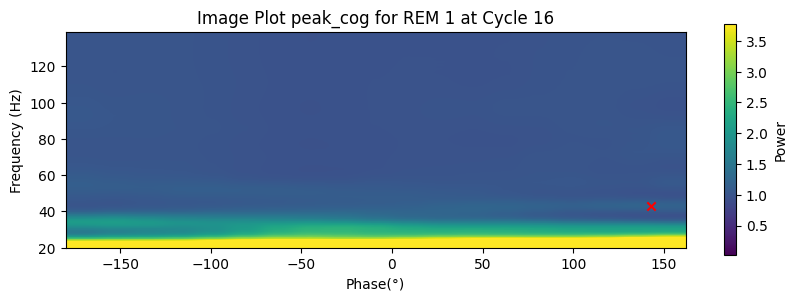

Calculated CoG: [70.07001741 53.63498246]
Calculated CoG: [76 67]


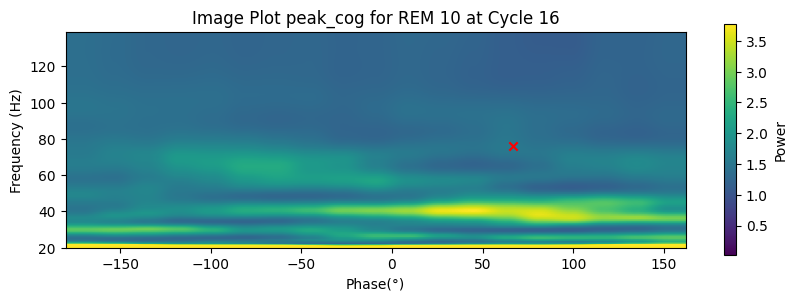

Calculated CoG: [66.53221399 54.28877479]
Calculated CoG: [54 29]


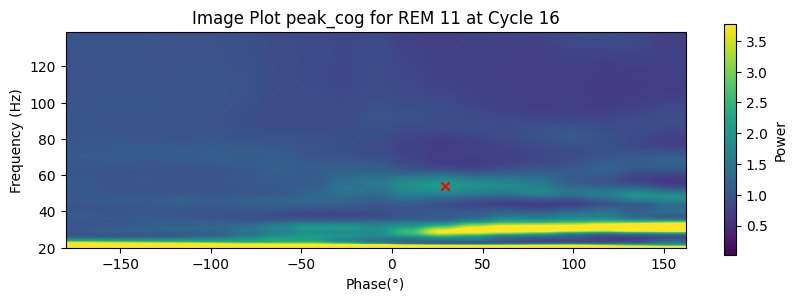

Calculated CoG: [ 63.47611148 120.73313411]
Calculated CoG: [ 66 143]


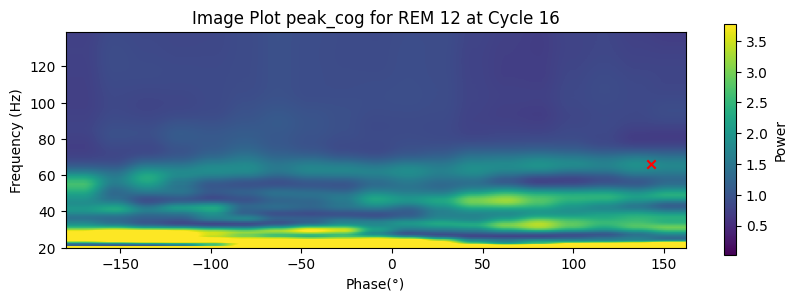

Calculated CoG: [ 60.35694595 163.25828713]
Calculated CoG: [  54 -161]


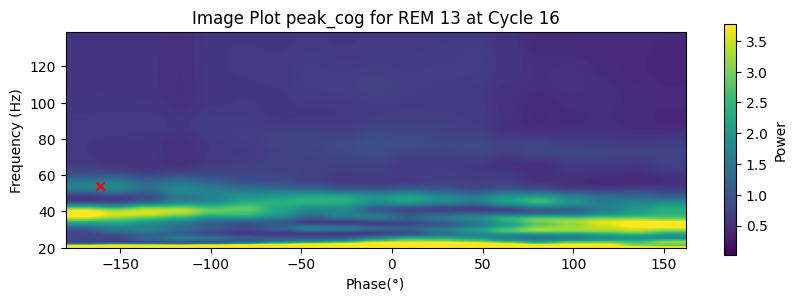

Calculated CoG: [ 64.14466948 -65.26623446]
Calculated CoG: [ 73 -47]


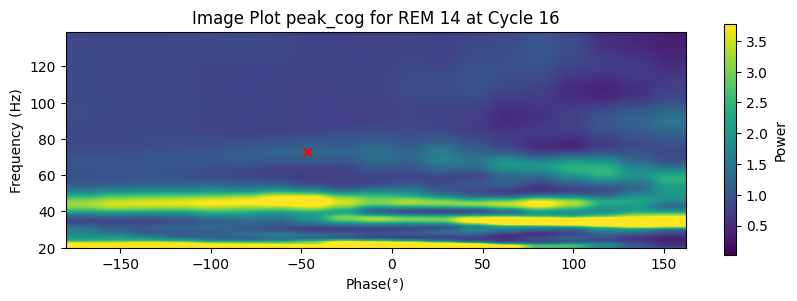

Calculated CoG: [ 66.36437563 116.52763934]
Calculated CoG: [ 72 105]


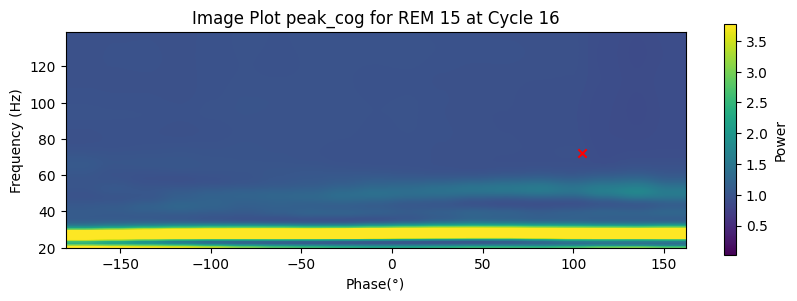

Calculated CoG: [ 61.89436932 -30.2391858 ]
Calculated CoG: [ 58 -47]


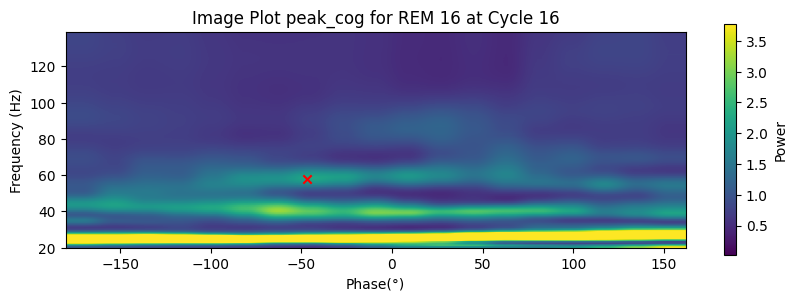

Calculated CoG: [62.44646908 96.68800355]
Calculated CoG: [39 67]


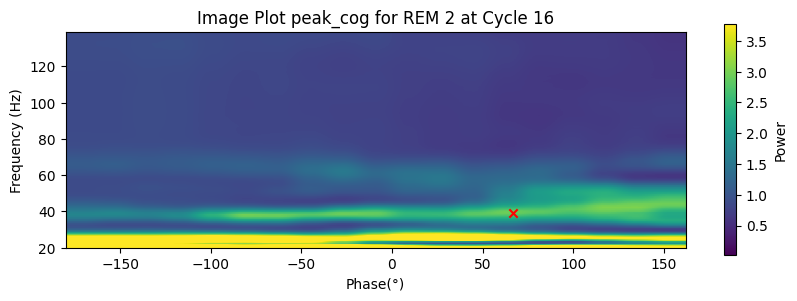

Calculated CoG: [ 66.16055608 114.88569111]
Calculated CoG: [ 59 105]


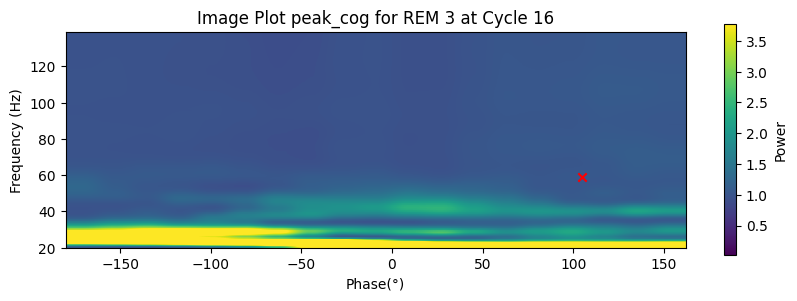

Calculated CoG: [68.2331905  37.35275863]
Calculated CoG: [75 29]


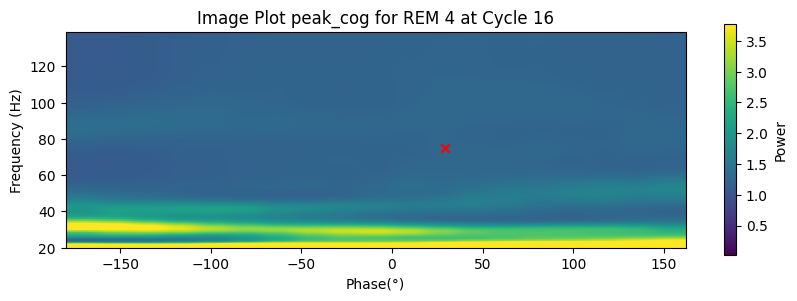

Calculated CoG: [ 65.31290118 116.95513906]
Calculated CoG: [ 55 143]


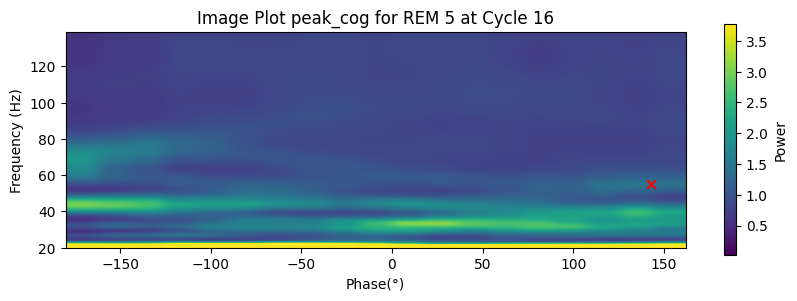

Calculated CoG: [65.28636423 -4.51781103]
Calculated CoG: [40 10]


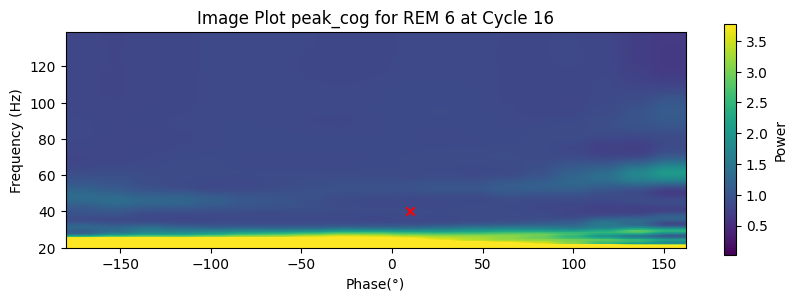

Calculated CoG: [  70.86740627 -134.67476995]
Calculated CoG: [  65 -123]


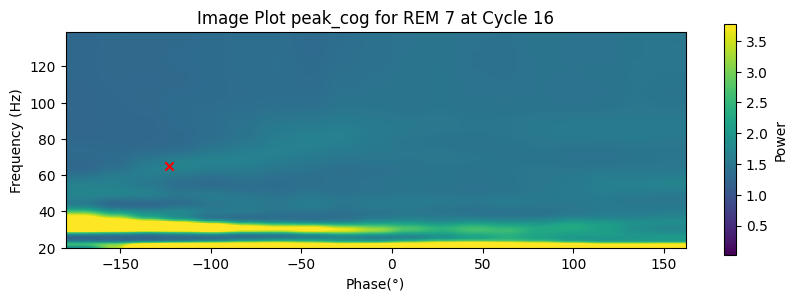

Calculated CoG: [62.49170442 72.77553148]
Calculated CoG: [60 48]


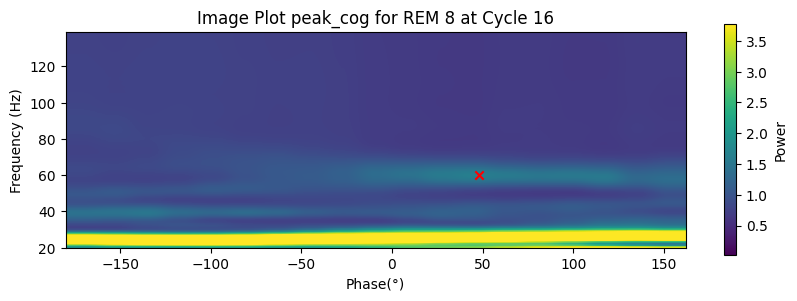

Calculated CoG: [  66.64580809 -110.64528675]
Calculated CoG: [ 62 -85]


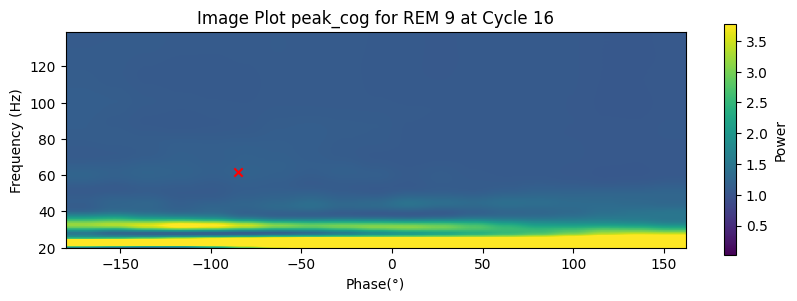

In [5]:
frequencies = np.arange(20, 140, 1)
angles = np.arange(-180, 180, 19)


# Specify the path to your specific HDF5 file
file_path = r'E:\Donders\1\processed\CN\post_trial5_2017-09-28_14-55-18\post_trial5_2017-09-28_14-55-18_REM_dict.h5'

# Check if the file exists
if os.path.isfile(file_path):
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as hdf_file:
        # Iterate over all groups in the file

        for group_name in hdf_file.keys():
            # Access the current group
            # Print debugging information
            print(f"Processing file: {file_path}")
            print(f"Available groups: {list(hdf_file.keys())}")
            current_group = hdf_file[group_name]

            # Continue with your processing for the current group
            rem_dict_keys = list(current_group.keys())
            fpp_max_list=[]
            fpp_min_list=[]
            for rem_key in rem_dict_keys:
                # Assuming you want to visualize a specific slice along the first dimension (e.g., index 100)
                slice_index = 16
            

                # Access the 'wavelet_transform' key for the current REM period
                wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                print(f"The shape of wavelet_transform for {rem_key} is: {wavelet_transform.shape}")

                # Square each value in the matrix to get power
                power_matrix = np.square(wavelet_transform)
                # Z-score along the frequency axis
                power = zscore(power_matrix, axis=0)
                #power = power_matrix

                shifted_power = power + np.abs(np.min(power))
                shifted_smoothed_power = boxcar_smooth(shifted_power, (5, 21))
                start_end = hdf_file[group_name][rem_key]['start-end'][:]
                fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                # Calculate mean power values for the subset of frequencies
                fpp_plots = bin_tf_to_fpp(newcycles, shifted_smoothed_power, 19).astype(np.float32)
                fpp_max = np.max (fpp_plots) # global maximum
                fpp_max_list.append(fpp_max)
                fpp_min = np.min (fpp_plots) # global minimum
                fpp_min_list.append(fpp_min)
            max_power=max(fpp_max_list)
            min_power=min(fpp_min_list)
            for rem_key in rem_dict_keys:
                # Access the 'wavelet_transform' key for the current REM period
                wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                # Square each value in the matrix to get power
                power_matrix = np.square(wavelet_transform)
                # Z-score along time
                power = zscore(power_matrix, axis=0)
                #power = power_matrix

                shifted_power = power + np.abs(np.min(power))
                #shifted_smoothed_power = boxcar_smooth(shifted_power, (5, 21))
                start_end = hdf_file[group_name][rem_key]['start-end'][:]
                fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                # Calculate mean power values for the subset of frequencies
                fpp_plots = bin_tf_to_fpp(newcycles, shifted_power, 19).astype(np.float32)
                calc_peaks = calculate_cog(frequencies, angles, fpp_plots[slice_index], 0.95)
                # Use the second dimension (19) for angles and the first dimension (120) for frequencies
                angles_slice = angles
                frequencies_slice = frequencies
                print("Calculated CoG:", calc_peaks)
                # Calculate snapped peaks for the subset of frequencies
                snapped_peaks = peak_cog(frequencies, angles, fpp_plots[slice_index], 0.95)

                # Use the second dimension (19) for angles and the first dimension (120) for frequencies
                angles_slice = angles
                frequencies_slice = frequencies
                print("Calculated CoG:", snapped_peaks)

                # Plot inside the loop for each rem_key
                plt.gcf().set_size_inches(10, 15)
                # Replace contourf with imshow and add extent, origin, vmin, and vmax
                plt.imshow(fpp_plots[slice_index], extent=[angles_slice[0], angles_slice[-1], frequencies_slice[0], frequencies_slice[-1]], origin='lower', vmin=min_power, vmax=max_power)
                plt.xlabel(r'Phase(°)')
                plt.ylabel(r'Frequency (Hz)')
                plt.title(f'Image Plot peak_cog for {rem_key} at Cycle {slice_index}')
                # Add a color bar with the same color map and range as the image plot
                # Shrink the color bar by 50%
                clb = plt.colorbar (cmap='hot', shrink=0.2)
                # Set the label of the color bar
                clb.set_label ('Power', size=10)

                # Scatter plot for snapped peaks
                plt.scatter(snapped_peaks[1], snapped_peaks[0], color='red', marker='x', label='Snapped Peak')
                # Place the legend outside the plot
                #plt.legend(loc="upper left", bbox_to_anchor=(1,1))

                plt.show()
else:
    print(f"The specified file '{file_path}' does not exist.")

In [13]:
print(f"The shape of fpp_plots: {fpp_plots.shape}")

The shape of fpp_plots: (503, 120, 19)


In [6]:
print(fpp_plots.shape)
print(slice_index)


(7, 120, 19)
7
